In [1]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt

from simpeg import maps
import simpeg.electromagnetics.time_domain as tdem
from simpeg.utils import plot_1d_layer_model

### Step 1: Make "True Model"

*** Note: For this first initial step, the model is simulating a 2 layer, ice/nonice model. The goal is to eventually build up a model with more realistic properties

In [2]:
#specify parameters

#conductivity
ice_sigma = 10**4 #taken from reference paper
nonice_sigma = 10**3
sigmas = np.r_[ice_sigma, nonice_sigma, nonice_sigma]

#layer thickness
glacier_z = 150 #from reference paper
total_z = 600
non_glacier_z = total_z - glacier_z

thickness = np.r_[glacier_z,non_glacier_z]

#number of layers
n_layers = len(sigmas)

# Source properties
source_location = np.array([0.0, 0.0, 1.0])  #not specified in paper
source_orientation = "z"  # "x", "y" or "z"
source_current = 500  #A
source_radius = np.sqrt(499/np.pi) #m, approximation from a octagon

# Receiver properties
receiver_locations = np.array([0.0, 0.0, 1.0])  # or (N, 3) numpy.ndarray
receiver_orientation = "z"  # "x", "y" or "z"
times = np.logspace(-5, -2, 31)  # time channels (s)

In [3]:
#define waveforms
stepoff_waveform = tdem.sources.StepOffWaveform(off_time=0.0)

In [4]:
#define surveys 
receiver_list = []
receiver_list.append(
    tdem.receivers.PointMagneticFluxDensity(
        receiver_locations, times, orientation=receiver_orientation
    )
)

# Define source list. In our case, we have only a single source.
source_list = [
    tdem.sources.CircularLoop(
        receiver_list=receiver_list,
        location=source_location,
        waveform=stepoff_waveform,
        current=source_current,
        radius=source_radius,
    )
]

# Define the survey
survey = tdem.Survey(source_list)

Text(0.5, 1.0, 'True Model')

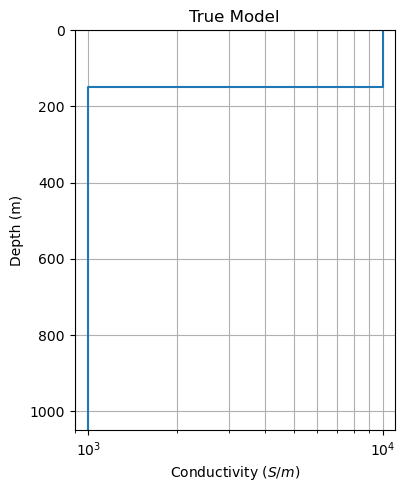

In [5]:
#Plot the model
fig = plt.figure(figsize=(4, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax1 = plot_1d_layer_model(thickness, sigmas, scale="log", ax=ax1)
ax1.grid(which="both")
ax1.set_xlabel(r"Conductivity ($S/m$)")
plt.title("True Model")

### 2. Forward Simulation

Im using the simplest conductivity model to test that the process works, might decide to change in the future

In [6]:
#define map and model
model = sigmas.copy()
sig_map = maps.IdentityMap(nP=n_layers)

In [7]:
simulation = tdem.simulation_1d.Simulation1DLayered(survey=survey, sigmaMap= sig_map, thicknesses=thickness)

In [22]:
dpred = simulation.dpred(model) #T

d_dpred = np.diff(dpred)
dt = np.diff(times)

dBdt = d_dpred/dt

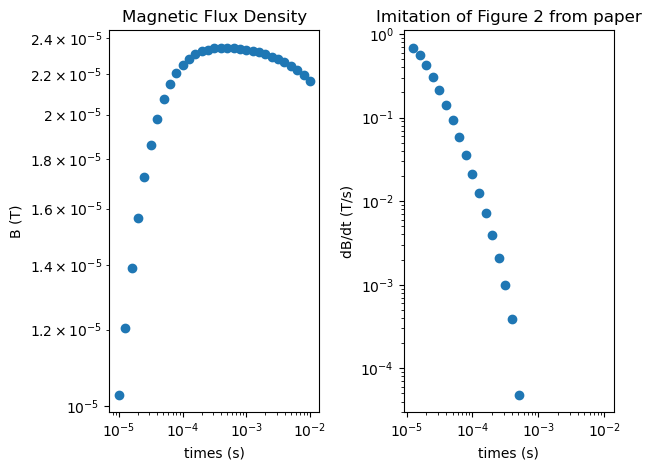

In [31]:
#Plot the predicted data
plt.subplot(1,2,1)
plt.loglog(times, dpred, "o")
plt.xlabel("times (s)")
plt.ylabel("B (T)")
plt.title("Magnetic Flux Density")

plt.subplot(1,2,2)
plt.loglog(times[1:], dBdt, "o")
plt.xlabel("times (s)")
plt.ylabel("dB/dt (T/s)")
plt.title("Imitation of Figure 2 from paper")

plt.tight_layout()